In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ase import Atoms
from tqdm import tqdm

from Constants import Keys, Dataset, Logging

In [2]:
data = np.load("./../Datasets/md17_aspirin.npz")
print(data.files)
data['E'].shape

['E', 'name', 'F', 'theory', 'R', 'z', 'type', 'md5']


(211762, 1)

In [3]:
def plot_loss(folder, skip=1):
    path = os.path.join("..", "Checkpoints", folder)
    # if not exist return
    if not os.path.exists(path) or not os.path.isdir(path):
        print(f"Folder {folder} does not exist")
        return
    log_path = os.path.join(path, "training_log.csv")
    # create dir for plots
    os.makedirs(os.path.join(path, "plots"), exist_ok=True)
    
    # load csv file with pandas
    log = pd.read_csv(log_path)
    
    # skip first epochs to get a better visualization of the loss
    log = log[skip:]
    
    # display total loss
    plt.figure(figsize=(10, 5))
    plt.plot(log[Logging.epoch_key], log[Logging.train_total_loss_key], label='Train Total Loss')
    try:
        plt.plot(log[Logging.epoch_key], log[Logging.val_total_loss_key], label='Validation Total Loss')
    except KeyError:
        pass
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # save plot in log folder
    plt.savefig(os.path.join(path, "plots", "total_loss.png"))
    plt.show()
    
    # display energy loss
    plt.figure(figsize=(10, 5))
    plt.plot(log[Logging.epoch_key], log[Logging.train_energy_loss_key], label='Train Energy Loss (kcal/mol)')
    try:
        plt.plot(log[Logging.epoch_key], log[Logging.val_energy_loss_key], label='Validation Energy Loss (kcal/mol)')
    except KeyError:
        pass
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # save plot in log folder
    plt.savefig(os.path.join(path, "plots", "energy_loss.png"))
    plt.show()
    
    # display force loss
    plt.figure(figsize=(10, 5))
    plt.plot(log[Logging.epoch_key], log[Logging.train_force_loss_key], label='Train Force Loss (kcal/mol/Å)')
    try:
        plt.plot(log[Logging.epoch_key], log[Logging.val_force_loss_key], label='Validation Force Loss (kcal/mol/Å)')
    except KeyError:
        pass
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # save plot in log folder
    plt.savefig(os.path.join(path, "plots", "force_loss.png"))
    plt.show()
    
    # display weights
    plt.figure(figsize=(10, 5))
    plt.plot(log[Logging.epoch_key], log[Logging.p_energy_key], label='P Energy')
    plt.plot(log[Logging.epoch_key], log[Logging.p_force_key], label='P Force')
    plt.xlabel('Epoch')
    plt.ylabel('Weight')
    plt.legend()
    # save plot in log folder
    plt.savefig(os.path.join(path, "plots", "weights.png"))
    plt.show()

Fixed prefactor scheme

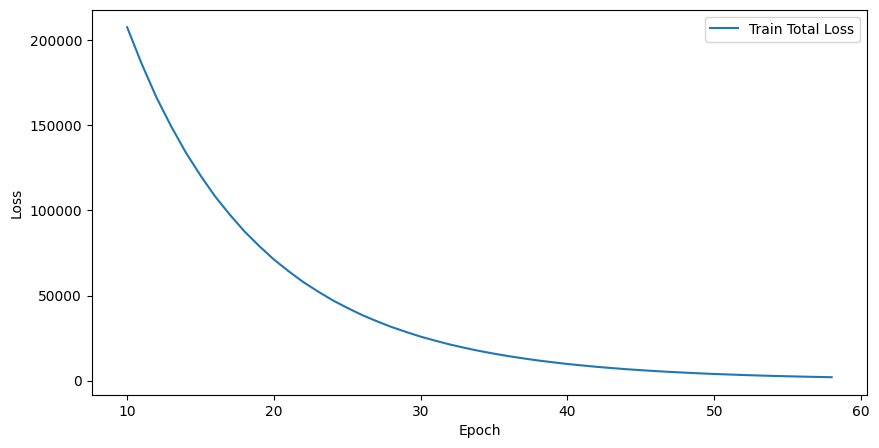

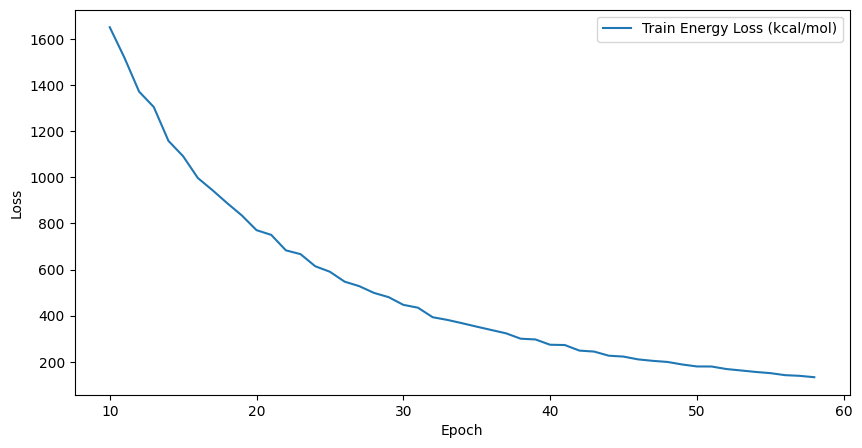

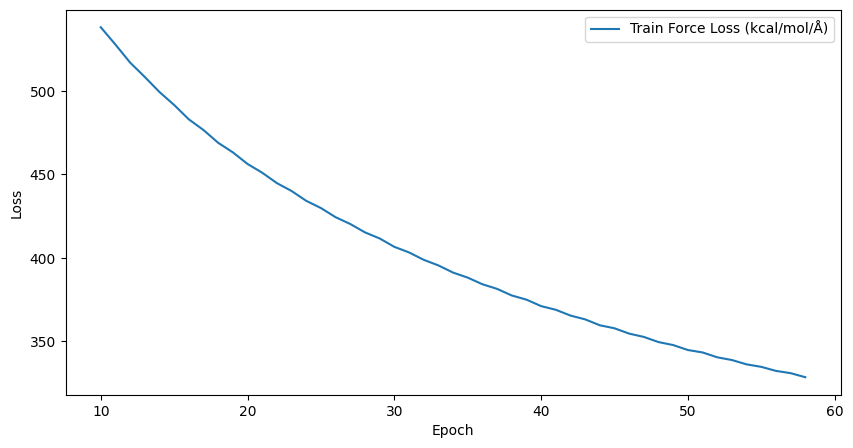

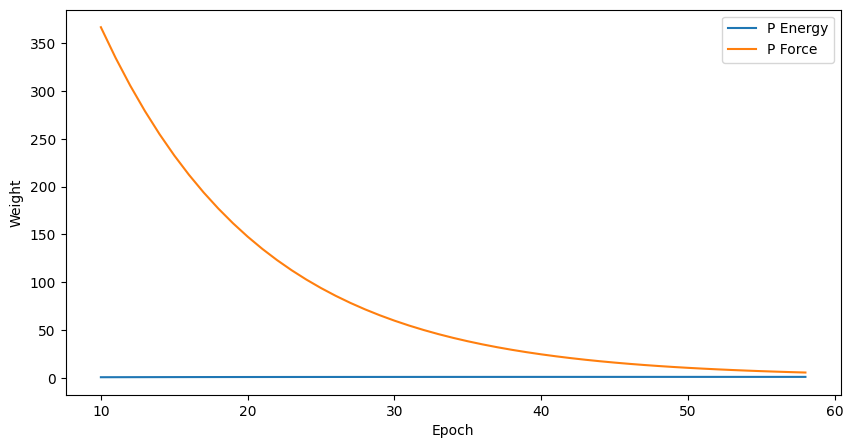

In [4]:
plot_loss("Model-aspirin_max_local_level_6_grid_size_1_n_samples_50000-DS-0.001-lr-15000.0-decay-steps11-54-22", skip=10)

In [12]:
path = os.path.join("..", "Datasets", "aspirin_grid_size_1.5_n_samples_40000", "val.pkl.gzip")
df = pd.read_pickle(path, compression="gzip")
df.head()

,energy,forces,atomic_numbers,positions,local_distance_matrix,local_atomic_numbers,long_range_distance_matrix,long_range_atomic_features,n_max_local,n_max_long_range
9,-406747.383296,"[[7.687831584094503, -25.23848389743499, 4.730...","[6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, ...","[[2.25371432, -0.38405914, 0.25593283], [0.836...","[[[2.8270380008208646, 0.5013029430762862, -0....","[[[6, 6], [6, 6], [6, 6], [6, 6], [6, 1], [6, ...","[[[5.846670732028887, 0.9904143114167501, -0.1...","[[[6, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0...",9,14
55,-406741.957874,"[[-42.38533110425632, -30.740087767996194, -10...","[6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, ...","[[2.36304368, -0.34213535, 0.21691393], [0.862...","[[[2.775653414030076, 0.5404691567099756, -0.8...","[[[6, 6], [6, 6], [6, 6], [6, 6], [6, 1], [6, ...","[[[5.953913521834249, 0.9781520677953967, -0.1...","[[[6, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0...",9,15
60,-406743.807567,"[[-49.782884695510745, -27.88165693154364, -14...","[6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, ...","[[2.34522732, -0.32257084, 0.20605715], [0.864...","[[[2.743495996530941, 0.5397548098748607, -0.8...","[[[6, 6], [6, 6], [6, 6], [6, 6], [6, 1], [6, ...","[[[5.913194210199719, 0.9785167167865244, -0.1...","[[[6, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0...",9,17
77,-406741.607621,"[[45.35561749916785, -27.066443318838452, 12.9...","[6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, ...","[[2.24354799, -0.3121744, 0.15801046], [0.8158...","[[[2.697646642702258, 0.5292561996073041, -0.8...","[[[6, 6], [6, 6], [6, 6], [6, 6], [6, 1], [6, ...","[[[5.736282338454301, 0.9783820334205712, -0.1...","[[[6, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0...",9,15
82,-406740.760367,"[[55.41289478105389, 4.124412729455345, 14.450...","[6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, ...","[[2.22367626, -0.32715976, 0.14638931], [0.812...","[[[2.7053229515186494, 0.5214812668513579, -0....","[[[6, 6], [6, 6], [6, 6], [6, 6], [6, 1], [6, ...","[[[5.717098302841191, 0.9775565909659857, -0.1...","[[[6, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0...",9,15


In [13]:
import tensorflow as tf

In [15]:
c = tf.constant(1.0, dtype=tf.float32)
c+1

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>